In [63]:
import zipfile, os, pprint
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from functions.functions import previous_yrs, opponent_stats

% matplotlib inline

# Read in files

In [2]:
_file = os.path.join('Data', 'finalgamedata.zip')
zf = zipfile.ZipFile(_file)
gamestats = pd.read_csv(zf.open('gamestats.csv'))
gamelist = pd.read_csv(zf.open('gameslist.csv'))
gamelist['opponentName'] = gamelist['opponentName'].str.replace("  ", " ")

In [3]:
# Fix time of possession 
gamestats.TOP = pd.to_timedelta(gamestats.TOP).astype('timedelta64[s]')
gamestats.def_TOP = pd.to_timedelta(gamestats.def_TOP).astype('timedelta64[s]')

In [4]:
# Create a list of the teams 
teamlist = list(gamelist['Team'].unique())

In [5]:
# Create the opponent's game list data for use later 
opponent_game_list_data = gamelist.copy(deep=True)
opponent_game_list_data.drop(['Opponent', 'Result', 'year', 'opponentName'], axis = 1, inplace = True)
opponent_game_list_data.rename(columns={'Team':'opponentName'}, inplace = True)

# Relabel the variables
opponent_game_list_columns = ['opp_'+ x if x not in ['Date', 'opponentName']
                              else x
                              for x in list(opponent_game_list_data.columns) 
                             ]

opponent_game_list_data.columns = opponent_game_list_columns

In [6]:
gamelist = gamelist.merge(opponent_game_list_data, 
                          left_on = ['opponentName', 'Date'],
                          right_on = ['opponentName', 'Date'], 
                          how = 'left'
                         );

# Target variables

In [7]:
cols = list(gamestats.columns )
target_variables = cols[cols.index('RushNetYards'):]
target_variables = [x for x in target_variables if x not in ['def_Opponent', 'gamenumber', 'year']]

target_variables = ["FG","RushNetYards","PassYards","Interceptions","Pct", "RZScores",
                    "Punts","FumblesLost","Penalties","Plays","def_RushNetYards","def_PassYards",
                    "def_Interceptions","def_Punts", "def_FF","def_PenaltyYards","def_PDef","Sacks","Tackles",
                    "def_Plays", "TOP"
                   ]

# Fill in game stats missing variables with zeros 

In [8]:
gamestats[target_variables] = gamestats[target_variables].fillna(value = 0, axis = 'columns')

# Create opponent variable names

In [9]:
# Create the opponent variable names 
opponent_variables = ['opp_' + x for x in target_variables]

# Create dataset

In [10]:
pd.set_option('display.max_columns', 1000)

In [11]:
base_year_mask = ~((gamelist.year == 2013) & (gamelist['gamenumber'] == 1))

In [12]:
gamelist[target_variables] = gamelist[base_year_mask].apply(lambda x: previous_yrs(team = x['Team'], 
                                                                                   year = x['year'], 
                                                                                   game = x['gamenumber'], 
                                                                                   cols = target_variables, 
                                                                                   gamestats = gamestats,
                                                                                   debug = False
                                                                                  ), 
                                                            axis = 1
                                                           )

In [13]:
# Subset the datset to only the needed games 
games = gamelist[base_year_mask].copy()

# Calculate the opponent game data 
games[opponent_variables] = gamelist.apply(lambda x: opponent_stats(team = x['Team'],
                                           date = x['Date'], 
                                           year = x['year'], 
                                           cols = target_variables,
                                           gamestats = gamestats,
                                           debug = False
                                          )
                             if x['opponentName'] in teamlist
                             else pd.Series([None for x in range(0, len(target_variables))]),
                             axis = 1
                            )

# Game list file variables to include

In [14]:
history = list(gamelist.loc[:, 'history_wins_1yrs':'history_WL_maxyrs'].columns)
coach = list(gamelist.loc[:, 'Coach_wins':'Coach_years'].columns)
opp_history = list(gamelist.loc[:, 'opp_gamenumber':'opp_history_WL_maxyrs'].columns)
opp_coach = list(gamelist.loc[:, 'opp_Coach_wins':'opp_Coach_years'].columns)
game_list_variables = target_variables + history + coach + opp_history + opp_coach

In [15]:
final_variables = game_list_variables

# Drop variables that have no variance 

In [16]:
variance_test = games[games.HomeAway == 1][final_variables].var().to_frame(name = 'variance').reset_index()
no_variance = list(variance_test[variance_test['variance'] == 0]['index'].values)
final_variables = [x for x in final_variables if x not in no_variance]

# Create variables for analysis 

In [17]:
y = games[games.HomeAway == 1]['WinLoss'].values
X = games[games.HomeAway == 1][final_variables].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)

# Run Grid Search on Random Forest Classifier

In [103]:
imputer = Imputer()
forest = RandomForestClassifier()

rf_feature = RandomForestClassifier(n_estimators = 100, 
                                    min_samples_split = 20, 
                                    random_state = 42,
                                    max_depth = 3
                                   )

feat_selection = SelectFromModel(rf_feature, threshold = .03) # Set a low threshhold to avoid failures 

In [104]:
pipe = Pipeline(steps=[('imputer', imputer), ('fs', feat_selection), ('forest', forest)])

In [105]:
random_grid_parameters = {  
                            'forest__criterion': ['gini', 'entropy'], 
                            'forest__max_depth':[x for x in range (1,6,1)], 
                            'forest__n_estimators':[100, 250, 500, 750, 1000, 1250], 
                            'forest__n_jobs':[-1], 
                            'forest__random_state':[42], 
                            'forest__min_samples_split':[x for x in range (10,50,5)],
                            'imputer__missing_values':['NaN'], 
                            'imputer__strategy':['mean'], 
                            'imputer__axis':[0], 
                           }

In [106]:
grid = RandomizedSearchCV(pipe, random_grid_parameters, cv=3, random_state = 42)
grid.fit(X=X_train, y=y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('fs', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_d...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'forest__criterion': ['gini', 'entropy'], 'forest__max_depth': [1, 2, 3, 4, 5], 'forest__n_estimators': [100, 250, 500, 750, 1000, 1250], 'forest__n_jobs': [-1], 'forest__random_state': [42], 'forest__min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45], 'imputer__missing_values': ['NaN'], 'imputer__strategy': ['mean'], 'imputer__axis': [0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
   

# Model Results

In [107]:
tree_model = grid.best_estimator_
print("Accuracy: {:0.2f}".format(grid.best_score_) )
print("Best Parameters:\t") 
pprint.pprint(grid.best_params_) 

Accuracy: 0.77
Best Parameters:	
{'forest__criterion': 'entropy',
 'forest__max_depth': 5,
 'forest__min_samples_split': 15,
 'forest__n_estimators': 1000,
 'forest__n_jobs': -1,
 'forest__random_state': 42,
 'imputer__axis': 0,
 'imputer__missing_values': 'NaN',
 'imputer__strategy': 'mean'}


# Feature Importance

In [108]:
feature_importance = grid.best_estimator_.named_steps['forest'].feature_importances_
x = list(zip(final_variables, feature_importance))
importance = pd.DataFrame(x, columns=['var', 'importance'])

In [109]:
# Print the importance values 
importance.sort_values('importance', ascending = False)

,var,importance
0,RushNetYards,0.152959
3,PuntRetYds,0.147246
4,FRetYds,0.142623
6,APY,0.142265
1,ReceivingYards,0.123230
2,IntRYds,0.112692
5,KORetYds,0.110846
7,FumblesRecovered,0.068141


# Test score

In [110]:
print('Test score: {:0.2f}'.format(grid.score(X_test, y_test)))

Test score: 0.76


# Predict Test 

In [111]:
y_pred = grid.predict(X_test)

# Plot the ROC Curve

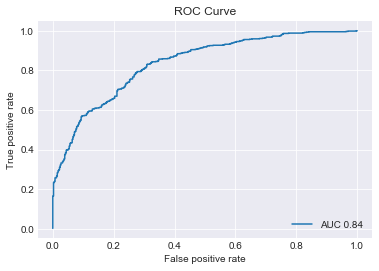

In [112]:
# Set seaborn style 
sns.set_style("darkgrid")

y_pred_proba = grid.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC" + " {:0.2f}".format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC Curve")
plt.legend(loc=4);


# Classification Report

In [113]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.76      0.60      0.67       408
          1       0.76      0.87      0.81       587

avg / total       0.76      0.76      0.75       995



# Confusion Matrix

In [114]:
confusion_matrix(y_test, y_pred)

array([[246, 162],
       [ 78, 509]])

In [115]:
grid.cv_results_;